# Audio Classification w. Convolutional Neural Networks

In this notebook, we will classify audio spectrograms into one of two classes.

## The Dataset

The dataset we are using consists of spectrograms of Stephen Colbert and Conan O'Brien speaking. It has been put together by Sean M. Tracey

The source videos from which the audio samples have been extracted, and the spectrograms generated from are:

Stephen Colbert:
- https://www.youtube.com/watch?v=U2_52Dj6DsI
- https://www.youtube.com/watch?v=m6tiaooiIo0

Conan O'Brien:
- https://www.youtube.com/watch?v=KmDYXaaT9sA
- https://www.youtube.com/watch?v=_q471WB5Tgw
- https://www.youtube.com/watch?v=DtJ28qOEG1g

The audio content is from different time periods across 2 decades. Once extracted from the videos, each audio file is divided into 250ms clips. These clips are then analysed to generate spectrograms that can be classified by a CNN.

## Installing Dependencies

In this notebook, we are using Keras with a Tensorflow backend to construct our neural network. Before we get started we need to install our dependencies.

In [1]:
!pip install tensorflow==1.13.1
!pip install keras==2.2.4
!pip install pydotplus
!pip install graphviz

## Getting the training data

Our training data consists of 2394 JPGs containing a spectrogram of the raw audio data from the processed video files. This dataset has been divided up into 3 different categories:

- training (75%)
- validation (20%)
- unseen (5%)

The `training` data will be used to train our model on the different patterns in Stephen Colbert and Conan O'Brien's speech. The `validation` data is used by the model to track how well it's doing in the current epoch. The `unseen` data is not used by the model, but is reserved by us to run some code later on in this notebook.

We'll retrieve these files from a DropBox folder and extract them to a working directory for our Keras script to use.

In [2]:
!mkdir -p ./data
!curl -L --output ./data/audio_data.zip https://www.dropbox.com/s/rbywvpnd7h3d5ra/audio_data.zip?dl=1
!unzip -o ./data/audio_data.zip -d ./data
!ls -la && ls -la ./data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 55.2M  100 55.2M    0     0  11.0M      0  0:00:04  0:00:04 --:--:-- 16.7M
Archive:  ./data/audio_data.zip
  inflating: ./data/unseen/colbert/58-0.wav.png  
  inflating: ./data/__MACOSX/unseen/colbert/._58-0.wav.png  
  inflating: ./data/unseen/colbert/5-31.wav.png  
  inflating: ./data/__MACOSX/unseen/colbert/._5-31.wav.png  
  inflating: ./data/unseen/colbert/83-8.wav.png  
  inflating: ./data/__MACOSX/unseen/colbert/._83-8.wav.png  
  inflating: ./data/unseen/colbert/20-7.wav.png  
  inflating: ./data/__MACOSX/unseen/colbert/._20-7.wav.png  
  inflating: ./data/unseen/colbert/31-18.wav.png  
  inflating: ./data/__MACOSX/unseen/colbert/._31-18.wav.png  
  inflating: ./d

## Requiring Dependencies

Here, we tell our Python runtime to import the dependencies we'll need to run our training and prediction scripts.

While not necessary to break out the different parts of Keras/OS/SciPy into different bits with `from blah import blah as blahblah`, it helps keep our code readable.

In [3]:
import sys, os
from os import listdir
from os.path import isfile, join
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf

from scipy import misc
import numpy as np

Using TensorFlow backend.


## Counting Available Files

Here, we're creating a tally of all of the source files we have for training our model. While not strictly neccesary to have something like this in our notebook, it is handy little bit of code that we can (and will) use to define our parameters for training later.

In [4]:
labelledClassesNames = [ dI for dI in os.listdir( 'data/train' ) if os.path.isdir(os.path.join( 'data/train', dI ) ) ]
labelledClasses = {}

for className in labelledClassesNames:
    
    trainingPath = 'data/train/' + className
    validationPath = 'data/validation/' + className

    labelledClasses[className] = {}
    labelledClasses[className]['training'] = len( [ f for f in listdir( trainingPath ) if isfile( join ( trainingPath, f ) ) ] )
    labelledClasses[className]['validation'] = len( [ f for f in listdir( validationPath ) if isfile( join ( validationPath, f ) ) ] )


In [5]:
labelledClassesNames

['conan', 'colbert']

In [6]:
print(labelledClasses['conan']['training'])
print(labelledClasses['conan']['validation'])

957
180


Let's now display some sample images, to get a feeling of what we are dealing with (40 images per folder, 4 folders: Conan and Colbert / Train and Validation):

Displaying: data/train/conan
Displaying: data/validation/conan
Displaying: data/train/colbert
Displaying: data/validation/colbert


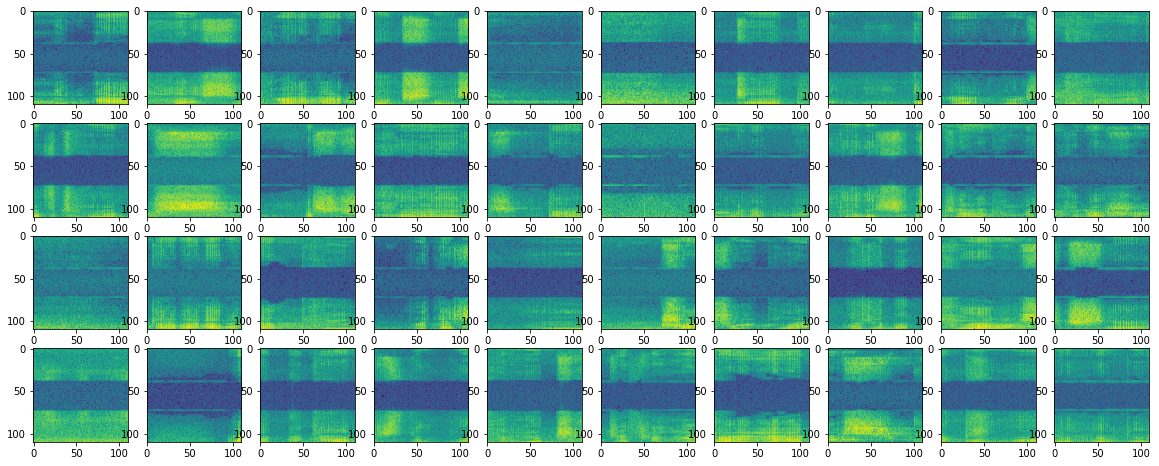

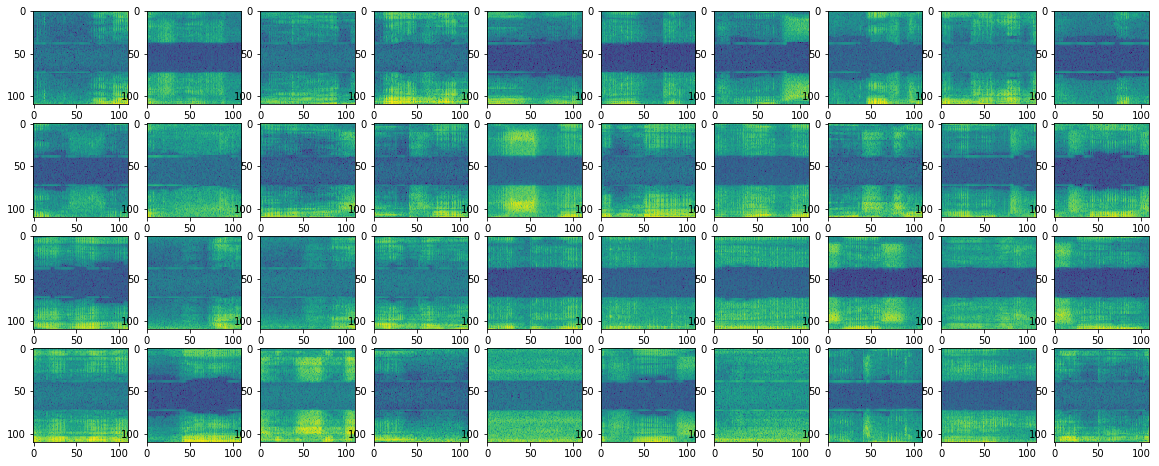

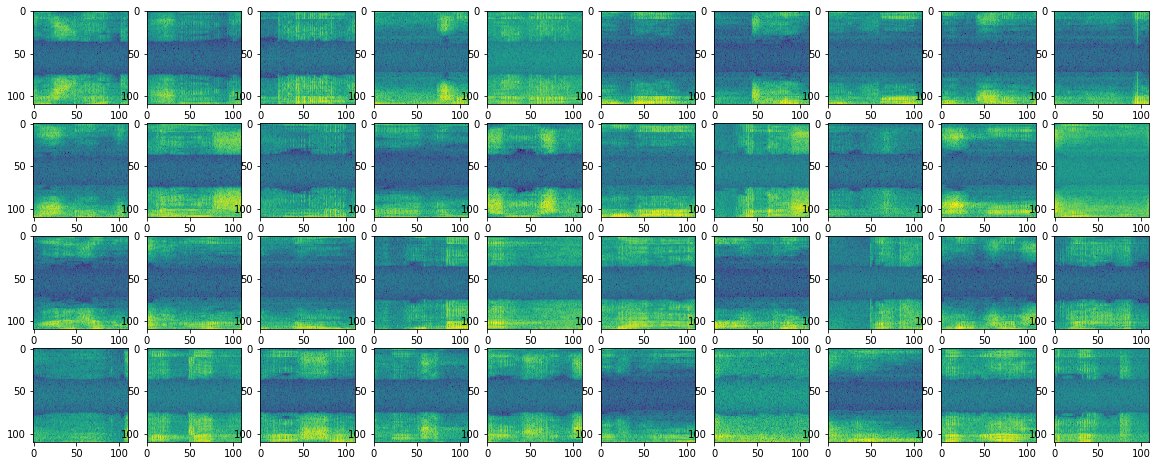

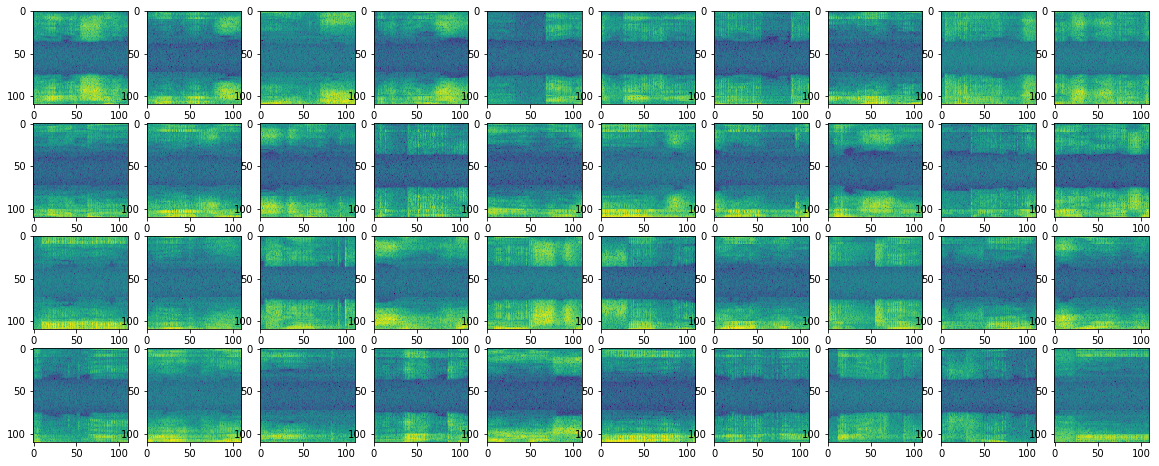

In [7]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

columns = 10
lines = 4

for className in labelledClassesNames:
    for curPath in ['train', 'validation']:
        totPath = 'data/'+curPath+'/'+className
 
        print(f'Displaying: {totPath}')
        images = []
        i = 0
        for img_path in glob.glob(totPath+'/*.png'):
            images.append(mpimg.imread(img_path))
            i += 1
            if i== columns*lines: break
        
        fig = plt.figure(figsize=(20,10))
        for i, image in enumerate(images):
            fig.add_subplot(len(images) / columns + 1, columns, i + 1)
            plt.imshow(image,interpolation='None', aspect='auto', )

plt.show()

## Preparing our data for our model

Here, we are setting variables that we will use to tell our generators (more on those later) how to train our model.

First, we create variables that we can use to point our code to the locations of our training and validation data on our filesystem (where we unzipped our data files in the early steps of this notebook)

Next, we create a variable which lists the number of training + validation files in our dataset. This is used later on in our dataset generators (some natty code which handles all the messy business of passing our training/validation data to our model) to determine the number of training steps are needed for each epoch.

Next, we set the number of epochs we want our training cycle to have. We don't want to have too many epochs as we have quite a small dataset, if we have too many epochs, our model will be trainined to recognise our dataset, not the speech patterns of the people we're trying to identify. This would negate our models efficacy in any environment outside of this notebook / dataset. 3 epochs on a dataset this size should give us a confidence of ~90% - 95%


In [8]:
# dimensions of our images.
img_width, img_height = 110, 110

train_data_dir = 'data/train' # The directory that our script will use to train our model
validation_data_dir = 'data/validation' # The directory that our script will use to validate the training of our model

nb_train_samples = labelledClasses[ labelledClassesNames[ 0 ] ]['training'] # The number of files we have to train our model
nb_validation_samples = labelledClasses[ labelledClassesNames[ 0 ] ]['validation'] # The number of files we have to validate our model

epochs = 10 # How many iterations (epochs) of our data will we pass through our model to train it.
batch_size = 16 # How many files from our training / validation dataset will we include in our batch at training time

# Depending on the backend Keras is running with, we either include the dimensions of our imnage before we include the number of channels
# This code sets the shape according to the backend included in the script.
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

## Constructing Our Model

It's time to start building our neural network!

In this next cell, we set the `model` variable. Here, we're telling our script that we want to create a sequential neural network, that is, a network which layers are triggered in tandem with each other, one layer after the other.

## Breaking down our neural network

Let's break down our layers line by line.

First, we have `model.add(Conv2D(32, (3, 3), input_shape=input_shape))` which, as the code suggests, creates a 2D convolutional layer. A convolutional layers job is to take an input (in this case, our image) and to essentially move around areas of it (convolve around) and tally up all of the values in that section of the image. Imagine you have a photo and a small square, if you were to place the square over a part of the image and tally up all of the values of the image inside the grid you would get a single number. If you repeat this process for all of the remaining parts of the image, you would end up with a matrix of numbers which you would then pass on to the next layer of our network. You can think of it as a filter. Our image goes in, the **_key features_** of our image are what is output, and that's what's important - we're hoping (and hope is the right word here) that our convolutional layer will be able to pick out the key features of our spectrograms as we show it more and more of them. This layer has `32` outputs, so we're greatly reducing the amount of information (A 110x110 image has 12,100 data points) passing from our source to the next layer of our network.

Next up, we have `model.add(Activation('relu'))`. This creates a layer of densely connected tensors (that is, a series of tensors which connects to every input and output before it) that will be activated with the **ReLu** function. The **ReLu** activation function is generally the go-to choice of activation functions when building convolutional neural networks. It's uncomplicated (it ignores negative input values), so it's computationally cheap to process, meaning we can usually train our networks faster with results comparative to networks built with other activation functions.

Finally, we have `model.add(MaxPooling2D(pool_size=(2, 2)))`. A pooling layer take only the highest values of a section of the inputs. Essentialluy this is a downsampling function which only allows the most prominent features of the inputs to remain. In this pooling layer, we're passing a pool size of `2x2`, that is, we're dividing the images into quadrants and passing the maximum values found in those quandrants to the next layer of our neural network.

In [9]:
model = Sequential()

# First Group
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

Instructions for updating:
Colocations handled automatically by placer.


## Finding Higher Level Features

Here, we repeat the stucture of our network. In our second group of layers, we have the same number of inputs as the output of our original layer of convolutional layer. Afterwards we have a second layer of activation nodes, followed by another pooling layer.

By adding more neurons to our convolution layer in `model.add(Conv2D(64, (3, 3)))` we create in our network the possibility of exploring more higher level features. If we're looking for images of cats, we can imagine the first layers in the first group of layers of our neural network would have identified the edges of objects. The second and third groups of convolutional layer gives our network the opportunity to explore connections between different features identified in the first group of layers. So, as opposed to finding the edge of features in an image, the network can start to look at the relationships between those featurs identified in the first group of layers in our network. Going back to thinking about cats, it's a bit like being able to say "This thing has ears (identification made in our first layer) but it also has four paws (exposed by the greater feature exploration enabled in our second layer)" 

In [10]:
# Second Group
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Group
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

## Flattening Our Output

At this point, after a number of epochs, our network will hopefully have built up enough information on the features in our spectrograns to adjust the weights which connect our neurons in a way that corresponds to an output that we expect - that is, it should be able to tell the difference between Stephen Colbert speaking and Conan O'Brien.

In our fourth group of layers, we flatten our input (essentially create a one-dimensional array of numbers which we can feed into our next layer) and create a densely connected layer of neurons which have **ReLu** activation. This ensures that none of the neurons in the previous layers aren't ultimately connected to the subsequent series of layers in our network.

In [11]:
# Fourth Group
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

## Classifying our data

Here we arrive at our final group of layers. First, we have a dropout layer `model.add( Dropout(0.5) )`. When we speak of "dropout" in a neural network, we're talking about the process whereby neurons are randomly selected be ignored during the forward and backpropogation of data in our training stages. This has the effect of making our networks more robust to overfitting to our dataset, thus (hopefully) being able to better to classify inputs from more varied sources than that of our dataset. In this instance, we're dropping about half of the neurons from our network at random during training.

Next we have a final densely connected layer `model.add( Dense( len( labelledClasses ) ) )`. The number of neurons in this layers corresponds to the number of classes our dataset has. This is the place where a decision is effectively made on what label the input data should have in our neural network.

Finally, we add a layer of activation neurons using a sigmoid function. The sigmoid function gives us a nice, curvy decider function that skirts around linearity. It inherently allows for nuance in deciding whether a thing is thing A or thing B based on the input.

In [12]:
# Fifth Group
model.add( Dropout(0.5) )
model.add( Dense( len( labelledClasses ) ) )
model.add( Activation('sigmoid') )

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Compiling Our Model

And that's it! We've constructed a very simple neural network to classify our spectrograms. Now it's time to compile our model to ready it for training.

In our `model.compile` code, we pass an optimizer, a loss function, and the metric that we use to measure the accuracy of our network.

The purpose of our optimiser is to best figure out how to update the weights of the connection between the neurons to minimise the loss function. Here, we're using the **ADAM** (**Ada**ptive **M**oment Estimation) optimiser.

Next, we pass the loss function in this case we're using the `categorical_crossentropy` loss function to calculate the difference between the expected output and the actual output that our model produces. This loss function is generally used for networks where there are more than two classes to identify (in that case, we could use a `binary_crossentropy` loss function), but by using the `categorical_crossentropy` function, we can use the same code that can manage classification of more than two types of classes. For the loss function, smaller number is better.

Finally, we have the metric that we use to measure the performance of our model. There can be a combination of metrics to measure the performance of our model, but here, we're only using `accuracy`.

In [13]:
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Plotting Our Model
We plot the model, to get an visual representation of the built architecture. This is achieved by using the Keras function that saves the resulting image to a file. We then reload the file to display it in the notebook.

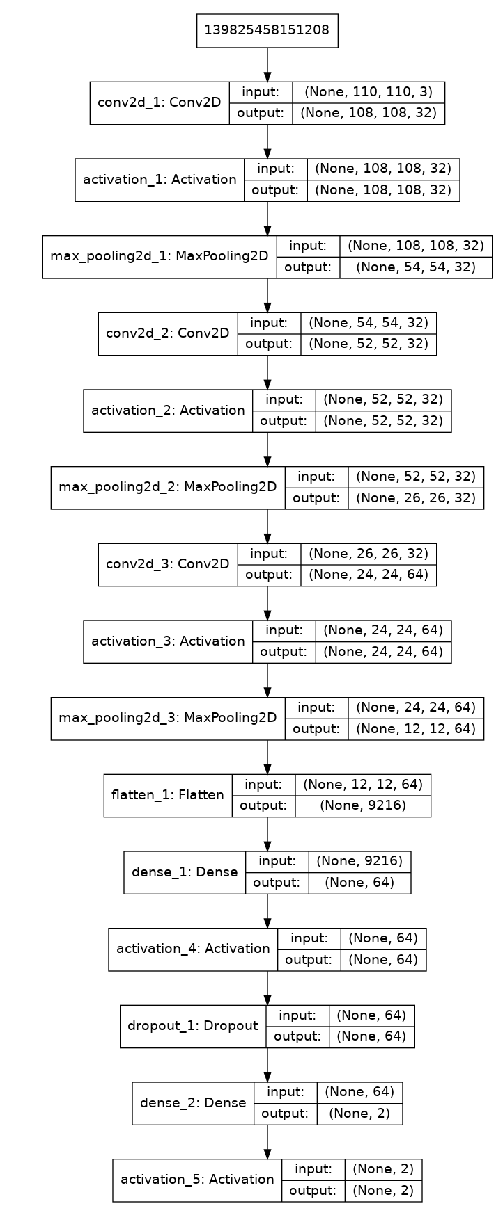

In [19]:
import pydotplus
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydotplus

tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'
)

import matplotlib.image as mpimg
image = mpimg.imread("model.png")
fig = plt.figure(figsize=(10,22))
plt.axis("off")
plt.imshow(image)
plt.show()

## Feeding our data into our model

Now that we have our model compiled, we can start funelling our data into it to train it 🎉

Keras has "generators" which can look at a directory structure, identify the classes therein, and then feed the data into our model.

We need two generators, one for the feeding the training data into our model, the other for feeding the validation data into our model.

For this, we create the `train_datagen` and `test_datagen` variables. Our model needs to have values between 0 and 1 to function correctly, so when we call the `ImageDataGenerator` function to create the generator, we tell it to divide all of the values it finds in the file by `255` the maxiumum number a pixel in our images.

In our `train_generator` and `validation_generator`, we pass through the directories that Keras can find our divvied-up dataset in (remember when we unzipped that file _ages_ ago? Well, now we get to use it). 

In both of our generators, we pass a target size tuple. If we had large images in our dataset, this would rescale them to a more manageable size for our network to handle. We don't necessarily need a high resolution image for our model to work. In this case, our images are `110 x 110` pixels. This is small enough that we should have enough data for our model to figure out any patterns in our spectrograms, but small enough that the model should train within a few minutes.

In [20]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255 )
test_datagen = ImageDataGenerator(rescale = 1.0 / 255 )

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size
)

Found 1914 images belonging to 2 classes.
Found 360 images belonging to 2 classes.


## Training our model

And here we are, at the point where we get to train our model.

If we hadn't used a generator to load our dataset, we could have called `model.fit` with a set of numpy arrays describing our data, but the generator is a nice way of quickly getting our model up and running. It's job is to break our training job into a smaller series of batches (a step) for training so that we don't have to load all of our data into memory at once. Though not a problem in this instance, large datasets may cause _out of memory_ errors when we try to train our model by overwhelming the systems capabilities. By breaking the training process up into smaller jobs, we can train our models on machines that don't neccesarily have an abundance of resources.

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta = 0.005)
# This callback will stop the training when there is no improvement in
# the validation loss for two consecutive epochs.

history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    use_multiprocessing=True,
    workers=6)

Instructions for updating:
Use tf.cast instead.


/opt/conda/envs/Python36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
59/59 [==============================] - 24s 413ms/step - loss: 0.6430 - acc: 0.6091 - val_loss: 0.8556 - val_acc: 0.5568
Epoch 2/10
59/59 [==============================] - 20s 332ms/step - loss: 0.5316 - acc: 0.7368 - val_loss: 0.2191 - val_acc: 0.9830
Epoch 3/10
59/59 [==============================] - 21s 359ms/step - loss: 0.2008 - acc: 0.9370 - val_loss: 0.0500 - val_acc: 0.9858
Epoch 4/10
59/59 [==============================] - 21s 355ms/step - loss: 0.0812 - acc: 0.9751 - val_loss: 0.0576 - val_acc: 1.0000
Epoch 5/10
59/59 [==============================] - 23s 393ms/step - loss: 0.0740 - acc: 0.9841 - val_loss: 0.0195 - val_acc: 1.0000
Epoch 6/10
59/59 [==============================] - 22s 367ms/step - loss: 0.0800 - acc: 0.9772 - val_loss: 0.0104 - val_acc: 1.0000
Epoch 7/10
59/59 [==============================] - 21s 349ms/step - loss: 0.0921 - acc: 0.9793 - val_loss: 0.0622 - val_acc: 0.9716
Epoch 8/10
59/59 [==============================] - 23s 384ms/step - 

In [22]:
# re-initialize our testing data generator, this time for evaluating
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    shuffle=False
)
validation_generator.classes

Found 360 images belonging to 2 classes.


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [23]:
# make predictions on the testing images, finding the index of the
# label with the corresponding largest predicted probability
predIdxs = model.predict_generator(validation_generator,
	steps=nb_validation_samples*2)
predIdxs = np.argmax(predIdxs, axis=1)

print(len(predIdxs))
predIdxs

360


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [24]:
# show a nicely formatted classification report
from sklearn.metrics import classification_report
print("[INFO] evaluating network...")
print(classification_report(validation_generator.classes, predIdxs,
	target_names=labelledClassesNames))


[INFO] evaluating network...
              precision    recall  f1-score   support

       conan       0.98      1.00      0.99       180
     colbert       1.00      0.98      0.99       180

   micro avg       0.99      0.99      0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



We now plot two curves built while training the model: accuracy and loss. This shows the learning process: with each passing epoch, the model learns form the data from the training set (blue curve) and the validation set is used to confirm the learing does generalize, i.e. it applies successfully to this data (orange curve). The loss goes down with each epoch, which means the learning is efficiently progressing. The accuracy grows accordingly, reaching a quite excellent value.

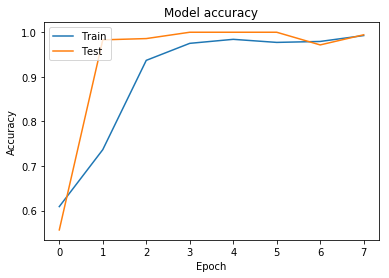

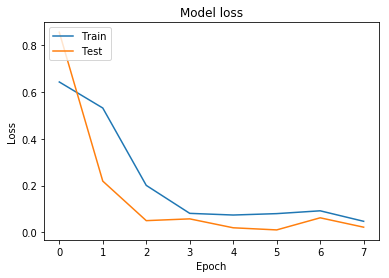

In [25]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Saving Our Model

After our model has gone through however many epochs of training we've asked it to do, we can save it!

By calling `model.save` we can pass a filename through to the function which will write a file. This will write the structure of the network as well as the weights between each neuron to a file, which makes it perfect for loading somewhere else. If you run the cell after `model.save` (`!ls -la`) you'll see that we now have the file `model.h5`.

In [26]:
model.save('model.h5')

In [27]:
!ls -la

total 7432
drwxr-x--- 3 dsxuser dsxuser    4096 Jan 30 11:36 .
drwx------ 1 dsxuser dsxuser    4096 Jan 30 08:28 ..
drwxr-x--- 6 dsxuser dsxuser    4096 Jan 30 08:28 data
-rw-r----- 1 dsxuser dsxuser 7476512 Jan 30 12:48 model.h5
-rw-r----- 1 dsxuser dsxuser  116464 Jan 30 12:44 model.png


## Loading + Predicting w. Our Model

So, we've trained a model, but what good is that to us if we can't predict things with it? In this next cell, we'll load the model we just wrote to a file and use it to classify the data that we seperated from our dataset earlier on (the unseen data).

This is data that the model has never seen - not during training, and not during validation - so if our model is any good, it should be able to pick out which of our two speakers are talking in each file.

This code will get all of the files in the `unseen` folder in our `data` folder and classify each one of them adding to a tally for each speaker.

First, we identify all of the classes in our data structure with `labelledClassesNames`, then we create a `tally` variable which will maintain a count of each correct and incorrectly identified speakers. 

In [28]:
stored_model = keras.models.load_model('model.h5')

labelledClassesNames = [ dI for dI in os.listdir( 'data/unseen' ) if os.path.isdir( os.path.join( 'data/unseen', dI ) ) ]
labelledClasses = {}

tally = {}

for className in labelledClassesNames:
    
    if className not in tally:
        tally[className] = { "correct" : 0, "incorrect" : 0 }

    unseenPath = 'data/unseen/' + className

    for f in os.listdir( unseenPath ):

        if os.path.isfile( os.path.join ( unseenPath, f ) ) and f != ".DS_Store":

            filePath = unseenPath + "/" + f

            spectrogramFile = keras.preprocessing.image.load_img(filePath, target_size=(110,110))
            spectrogramFile = np.reshape(spectrogramFile, [1,110,110,3])
            prediction = stored_model.predict_classes( spectrogramFile )

            if className == "colbert" and prediction == 0:
                tally[className]["correct"] += 1
            elif className == "colbert" and prediction == 1:
                tally[className]["incorrect"] += 1

            if className == "conan" and prediction == 1:
                tally[className]["correct"] += 1
            elif className == "conan" and prediction == 0:
                tally[className]["incorrect"] += 1

print(tally)


{'conan': {'correct': 60, 'incorrect': 0}, 'colbert': {'correct': 60, 'incorrect': 0}}


As a final cross check, we apply the same model to the validation data set, in order to make sure this is consistent with previously obtained results.

In [29]:
tally = {}

for className in labelledClassesNames:
    
    if className not in tally:
        tally[className] = { "correct" : 0, "incorrect" : 0 }

    unseenPath = 'data/validation/' + className

    for f in os.listdir( unseenPath ):

        if os.path.isfile( os.path.join ( unseenPath, f ) ) and f != ".DS_Store":

            filePath = unseenPath + "/" + f

            spectrogramFile = keras.preprocessing.image.load_img(filePath, target_size=(110,110))
            spectrogramFile = np.reshape(spectrogramFile, [1,110,110,3])
            prediction = stored_model.predict_classes( spectrogramFile )

            if className == "colbert" and prediction == 0:
                tally[className]["correct"] += 1
            elif className == "colbert" and prediction == 1:
                tally[className]["incorrect"] += 1

            if className == "conan" and prediction == 1:
                tally[className]["correct"] += 1
            elif className == "conan" and prediction == 0:
                tally[className]["incorrect"] += 1

print(tally)

{'conan': {'correct': 176, 'incorrect': 4}, 'colbert': {'correct': 180, 'incorrect': 0}}
